In [1]:
# Here we take care of paths.
# Make sure root project directory is named 'VESUVIUS_Challenge' for this to work

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-18:] == 'VESUVIUS_Challenge':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in the root folder of the project
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/VESUVIUS_Challenge/jupyter notebooks
Current path:/Users/gregory/PROJECT_ML/VESUVIUS_Challenge


In [30]:
import torch
import monai
from monai.visualize import matshow3d
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from typing import Tuple, List
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from Data_Modules.Vesuvius_Dataset import Vesuvius_Tile_Datamodule
from lit_models.Vesuvius_Lit_Model import Lit_Model
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.nn as nn
import torchvision

from Models.pvtv2 import PyramidVisionTransformerV2
import timm


PyramidVisionTransformerV2(img_size=256,
                                   patch_size=4,
                                   in_chans=4,
                                   num_classes=1,
                                   embed_dims=[64, 128, 256, 512],
                                 num_heads=[1, 2, 4, 8],
                                   mlp_ratios=[4, 4, 4, 4],
                                   qkv_bias=False,
                                   qk_scale=None,
                                   drop_rate=0.,
                                    attn_drop_rate=0.,
                                   drop_path_rate=0.,
                                   norm_layer=nn.LayerNorm,
                                   depths=[3, 4, 6, 3],
                                 sr_ratios=[8, 4, 2, 1],
                                   num_stages=4, 
                                        linear=False)

In [11]:
PATCH_SIZE = 256
Z_DIM = 16
COMPETITION_DATA_DIR_str =  "kaggle/input/vesuvius-challenge-ink-detection/"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

# change to the line below if not using Apple's M1 or chips
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [26]:
from timm.models.pvt_v2 import PyramidVisionTransformerV2,  default_cfgs
from timm.models.helpers import load_pretrained
from copy import deepcopy



In [27]:
pvt_default_cfg = default_cfgs['pvt_v2_b3']
pvt_model = PyramidVisionTransformerV2(num_classes=1, in_chans=4,)

In [34]:
PATCH_SIZE = 224
Z_DIM = 4
COMPETITION_DATA_DIR_str =  "kaggle/input/vesuvius-challenge-ink-detection/"
#model =timm.create_model('pvt_v2_b1', pretrained=True)
class CFG:
    
    device = DEVICE
    
    THRESHOLD = 0.4
    use_wandb = False
    
    ######### Dataset #########
    
    # stage: 'train' or 'test'
    stage = 'train' 
    
    # location of competition Data
    competition_data_dir = COMPETITION_DATA_DIR_str
    
    # Number of slices in z-dim: 1<z_dim<65
    z_dim = Z_DIM
    
    # fragments to use for training avalaible [1,2,3]
    train_fragment_id=[2,3]
    
    # fragments to use for validation
    val_fragment_id=[1]
    
    

    
    
    batch_size = 8
    
    # Size of the patch and stride for feeding the model
    patch_size = PATCH_SIZE
    stride = patch_size // 2
    
    
    num_workers = 0
    on_gpu = True
    
    
    ######## Model and Lightning Model paramters ############
    
    # MODEL
    model = smp.Unet(encoder_name='mit_b3',
                     encoder_depth=5,
                     encoder_weights=None,
                     decoder_use_batchnorm=True,
                     decoder_channels=(256, 128, 64, 32, 16),
                     decoder_attention_type=None,
                     in_channels=3,
                     classes=1,
                     activation=None,
                     aux_params=None)
    
    
    
    
    checkpoint = None
    save_directory = None
    
    
    accumulate_grad_batches = 48 # experiments showed batch_size * accumulate_grad = 192 is optimal
    learning_rate = 0.0001
    eta_min = 5e-7
    t_max = 50
    max_epochs = 60
    weight_decay =  0.00001
    precision =16
    
    # checkpointing
    save_top_k=5
    
    monitor="FBETA"
    mode="max"
    
    
    ####### Augemtnations ###############
    
    # Training Aug
    train_transforms = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(patch_size, patch_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(patch_size * 0.3), max_height=int(patch_size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * z_dim,
            std= [1] * z_dim
        ),
        ToTensorV2(transpose_mask=True),
    ]
    

    
    # Validaiton Aug
    val_transforms = [
        A.Resize(patch_size, patch_size),
        A.Normalize(
            mean= [0] * z_dim,
            std= [1] * z_dim
        ),
        ToTensorV2(transpose_mask=True),
    ]
    
    # Test Aug
    test_transforms = [
        A.Resize(patch_size, patch_size),
        A.Normalize(
            mean=[0] * z_dim,
            std=[1] * z_dim
        ),

        ToTensorV2(transpose_mask=True),
    ]
        
    
    

In [5]:
dataset = Vesuvius_Tile_Datamodule(cfg=CFG)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

subvolume shape: torch.Size([8, 4, 224, 224])
inklabel shape: torch.Size([8, 1, 224, 224])


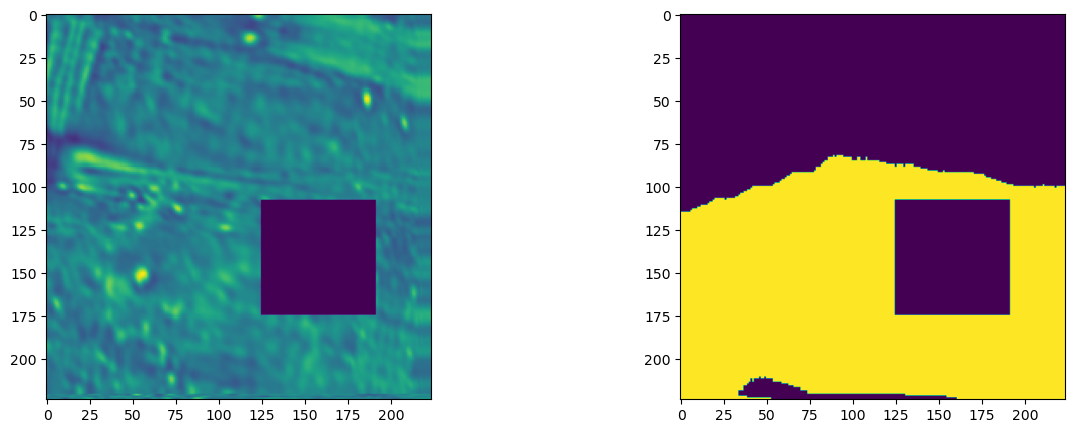

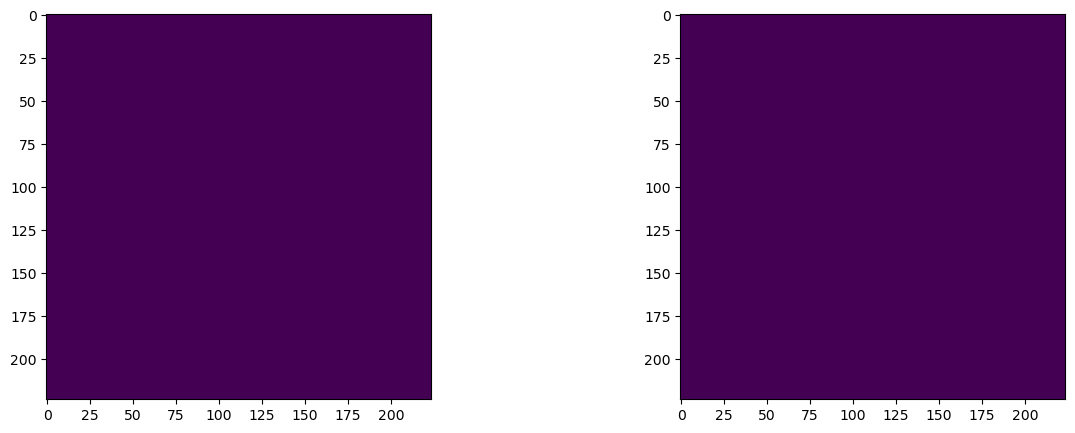

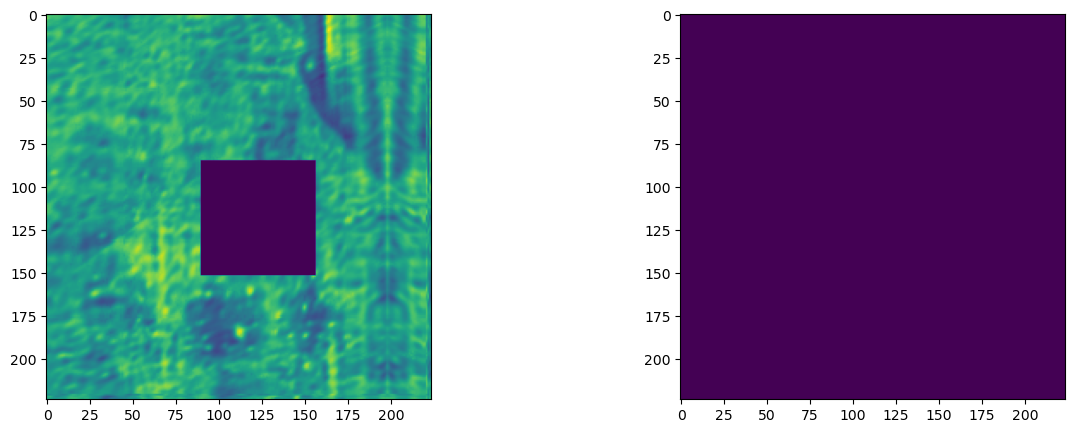

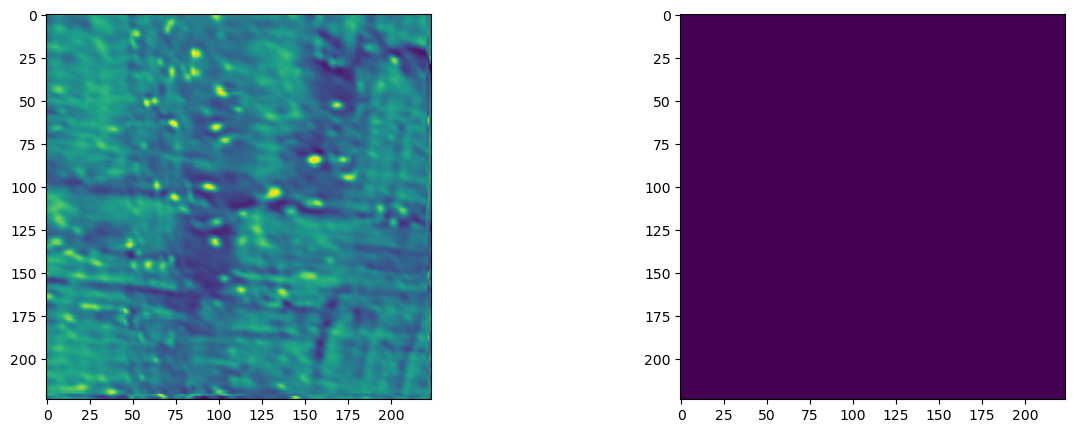

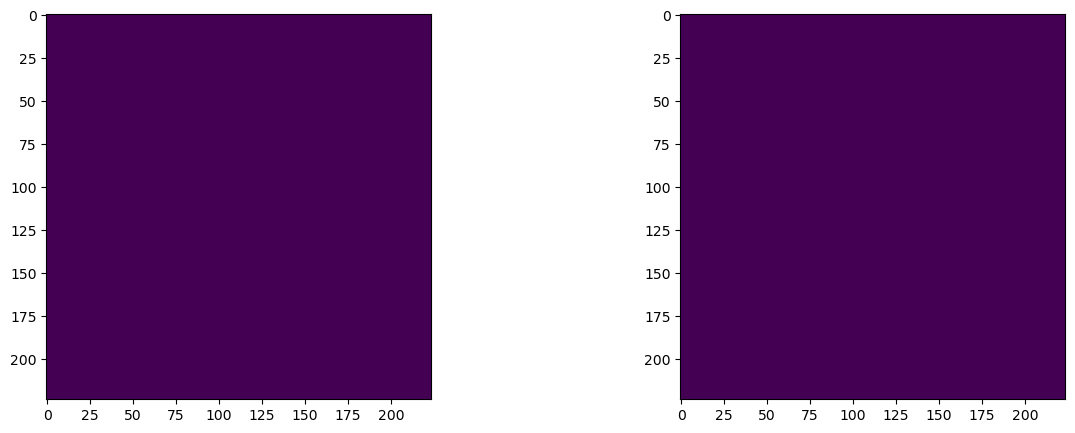

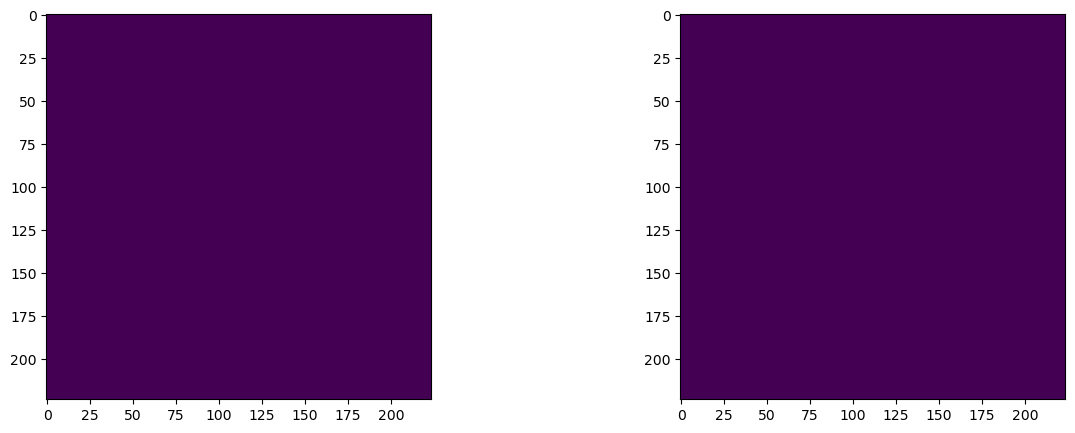

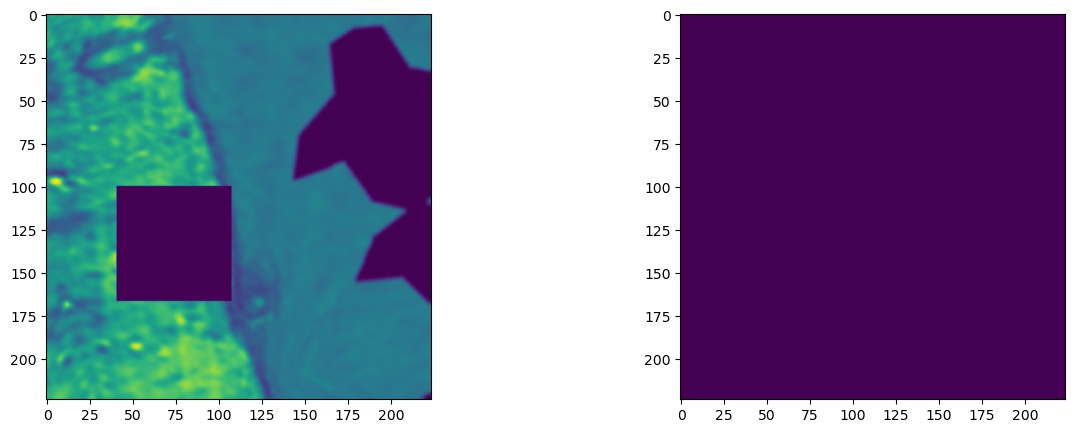

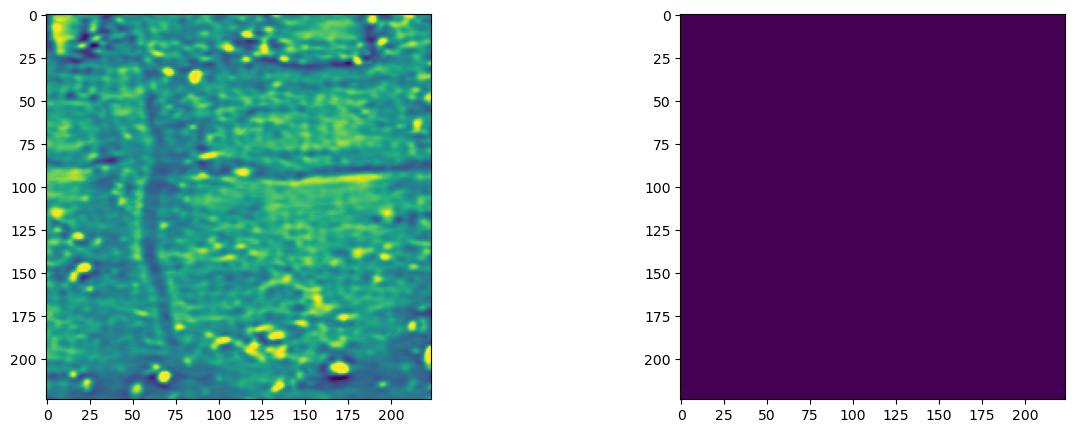

In [45]:
BATCHES_to_SHOW = 1

dataloader = iter(dataset.train_dataloader())
for i in range(BATCHES_to_SHOW):
    # Get image and label from train data -- change number for different ones
    subvolumes, inklabels = next(dataloader)
    print('subvolume shape:',subvolumes.shape)
    print('inklabel shape:',inklabels.shape)
    for subvolume,  inklabel in zip(subvolumes, inklabels):
                fig, axes = plt.subplots(1, 2, figsize=(15, 5))
                for idx, image in enumerate((subvolume,  inklabel)):
                    if idx==0:
                        axes[idx].imshow(image[0])
                    else:
                         axes[idx].imshow(image.squeeze(0))

                plt.show()
                

In [46]:
print(subvolumes.shape)
subvolumes = subvolumes.unsqueeze(1)
print(subvolumes.shape)

torch.Size([8, 4, 224, 224])
torch.Size([8, 1, 4, 224, 224])


In [47]:
print(subvolumes.shape)
subvolumes = subvolumes.repeat(1, 3, 1, 1, 1)
out = CFG.model(subvolumes)
print(subvolumes.shape,len(out),out[0].shape)


torch.Size([8, 1, 4, 224, 224])


ValueError: too many values to unpack (expected 4)

In [20]:
out = pvt_model(subvolumes)
print(subvolumes.shape,len(out),out[0].shape)

torch.Size([8, 4, 224, 224]) 8 torch.Size([1])


In [8]:
class Model(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.pre_model =monai.networks.nets.UNet(
                                        spatial_dims=3,
                                        in_channels=1,
                                        out_channels=1,
                                        channels=( 32, 64,128),
                                        strides=(2, 2,),
                                        num_res_units=2,
                                        dropout=0,
                                        norm='instance',
                                        bias =False,

                                    )
        
        self.model =monai.networks.nets.SwinUNETR(img_size = (256,256),
                                                      in_channels = 16 ,
                                                      out_channels = 1 ,
                                                      depths=(2, 2, 2, 2),
                                                      num_heads=(3, 6, 12, 24),
                                                      feature_size=24,
                                                      norm_name='instance',
                                                      drop_rate=0.0,
                                                      attn_drop_rate=0.0,
                                                      dropout_path_rate=0.0,
                                                      normalize=True,
                                                      use_checkpoint=False,
                                                      spatial_dims=2,
                                                      downsample='mergingv2')


        
    def forward(self, x):
        #x = self.pre_model(x)
        x = x.squeeze(1)
        out = self.model(x)
        return out
    
    
